In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Hyperparameters - significantly reduced for minimal CPU training
#BATCH_SIZE = 16
#BLOCK_SIZE = 64  # Reduced context window
#MAX_ITERS = 1000
#LEARNING_RATE = 1e-3
#DEVICE = 'cpu'  # Fixed to CPU
#EMB_SIZE = 64   # Reduced embedding dimensions
#HEAD_SIZE = 64  # Reduced head size
#NUM_HEADS = 2   # Reduced number of heads
#NUM_LAYERS = 2  # Reduced number of layers
#DROPOUT = 0.1   # Reduced dropout

# Modified hyperparameters
BATCH_SIZE = 16
BLOCK_SIZE = 64
MAX_ITERS = 1000
LEARNING_RATE = 1e-3
DEVICE = 'cpu' # Fixed to CPU
EMB_SIZE = 64  # Changed from 128 to 64 to match the embedding size
HEAD_SIZE = 32  # Changed from 64 to 32 to match the head output size
NUM_HEADS = 2  # Changed from 8 to 2 to match the number of heads
NUM_LAYERS = 2 # Changed from 8 to 2 to match the number of layers
DROPOUT = 0.1 # Reduced dropout

In [3]:
# Load and preprocess text
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Create vocabulary
chars = sorted(list(set(text)))
VOCAB_SIZE = len(chars)

print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
# Create encoding/decoding maps
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [5]:
# Create train/val split
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

class TextDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data) - self.block_size
    
    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y
    
dataset = TextDataset(train_data, BLOCK_SIZE)

# Print some example data
x, y = dataset[0]
print("Input tensor (x):", x)
print("Target tensor (y):", y)
print("\nDecoded input text:")
print(decode(x.tolist()))  # Convert tensor to list before decoding

# We can also see the relationship between input and target:
print("\nFirst few tokens as (input, target) pairs:")
for i in range(5):
    print(f"Position {i}: ({decode([x[i].item()])}, {decode([y[i].item()])})")

Input tensor (x): tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50])
Target tensor (y): tensor([47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44, 53,
        56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,  1,
        44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1, 57,
        54, 43, 39, 49,  8,  0,  0, 13, 50, 50])

Decoded input text:
First Citizen:
Before we proceed any further, hear me speak.

Al

First few tokens as (input, target) pairs:
Position 0: (F, i)
Position 1: (i, r)
Position 2: (r, s)
Position 3: (s, t)
Position 4: (t,  )


In [6]:
# Attention Mechanism
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(EMB_SIZE, head_size, bias=False)
        self.query = nn.Linear(EMB_SIZE, head_size, bias=False)
        self.value = nn.Linear(EMB_SIZE, head_size, bias=False)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = F.softmax(wei, dim=-1)
        
        # Weighted aggregation
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(NUM_HEADS)])
        self.proj = nn.Linear(head_size * NUM_HEADS, EMB_SIZE)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [7]:
# Feed Forward Block
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(EMB_SIZE, 2 * EMB_SIZE),
            nn.ReLU(),
            nn.Linear(2 * EMB_SIZE, EMB_SIZE),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
# Transformer Block, composed of Multi-Head Attention and Feed Forward blocks
class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.attention = MultiHeadAttention(HEAD_SIZE)
        self.ffwd = FeedForward()
        self.ln1 = nn.LayerNorm(EMB_SIZE)
        self.ln2 = nn.LayerNorm(EMB_SIZE)

    def forward(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [9]:
class ShakespeareTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.position_embedding = nn.Embedding(BLOCK_SIZE, EMB_SIZE)
        self.blocks = nn.Sequential(*[TransformerBlock() for _ in range(NUM_LAYERS)])
        self.ln_f = nn.LayerNorm(EMB_SIZE)
        self.lm_head = nn.Linear(EMB_SIZE, VOCAB_SIZE)
        
    def forward(self, idx):
        B, T = idx.shape
        
        # Get token and position embeddings
        tok_emb = self.token_embedding(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.position_embedding(pos)
        
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits
    
    def generate(self, idx, max_new_tokens, temperature=0.7):
        """Generate text with optional temperature control."""
        self.eval()  # Ensure model is in evaluation mode
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Get last block_size tokens or pad if needed
                if idx.size(1) < BLOCK_SIZE:
                    padding = torch.zeros((1, BLOCK_SIZE - idx.size(1)), dtype=torch.long, device=idx.device)
                    idx_cond = torch.cat([padding, idx], dim=1)
                else:
                    idx_cond = idx[:, -BLOCK_SIZE:]
                
                # Get predictions
                logits = self(idx_cond)
                logits = logits[:, -1, :] / temperature
                
                # Apply softmax with temperature
                probs = F.softmax(logits, dim=-1)
                
                # Sample from top-k tokens to avoid generating rare/garbage tokens
                top_k = 40
                top_k_probs, top_k_indices = torch.topk(probs, top_k)
                probs = torch.zeros_like(probs).scatter_(-1, top_k_indices, top_k_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)
                
                # Sample next token
                idx_next = torch.multinomial(probs, num_samples=1)
                
                # Append to sequence
                idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

In [10]:
train_dataset = TextDataset(train_data, BLOCK_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Total batches in one epoch: {len(train_loader)}")

Total batches in one epoch: 62737


In [14]:
'''
def train_model():
    model = ShakespeareTransformer()
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    train_dataset = TextDataset(train_data, BLOCK_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    best_loss = float('inf')
    start_time = time.time()
    
    # Training loop with progress tracking
    train_iter = iter(train_loader)
    for iteration in tqdm(range(MAX_ITERS), desc="Training Progress"):
        try:
            # Get batch
            try:
                xb, yb = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                xb, yb = next(train_iter)
            
            # Forward pass
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), yb.view(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print progress every 100 iterations
            if iteration % 100 == 0:
                print(f"\nIteration {iteration}: loss {loss.item():.4f}")
                
        except Exception as e:
            print(f"\nError in iteration {iteration}")
            print("Error details:", str(e))
            raise e

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    
    return model
'''
'''
def train_model():
    model = ShakespeareTransformer()
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    train_dataset = TextDataset(train_data, BLOCK_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    best_loss = float('inf')
    start_time = time.time()
    num_epochs = 3  # Increased number of epochs
    
    # Training loop with progress tracking
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_iter = iter(train_loader)
        running_loss = 0.0
        
        # Progress bar for each epoch
        num_batches = len(train_loader)
        progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}")
        
        for batch_idx in progress_bar:
            try:
                # Get batch
                try:
                    xb, yb = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    xb, yb = next(train_iter)
                
                # Forward pass
                logits = model(xb)
                loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), yb.view(-1))
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update running loss
                running_loss += loss.item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'avg_loss': f"{running_loss/(batch_idx+1):.4f}"
                })
                
                # Generate sample text every 500 batches
                if batch_idx % 500 == 0:
                    model.eval()
                    with torch.no_grad():
                        context = torch.zeros((1, 1), dtype=torch.long)
                        sample = model.generate(context, max_new_tokens=50, temperature=0.7)[0]
                        #print(f"\nSample text at batch {batch_idx}:")
                        #print(decode(sample.tolist()))
                        print("-" * 50)
                    model.train()
                
            except Exception as e:
                print(f"\nError in epoch {epoch+1}, batch {batch_idx}")
                print("Error details:", str(e))
                raise e
        
        # End of epoch stats
        avg_loss = running_loss / num_batches
        print(f"\nEpoch {epoch+1} completed. Average loss: {avg_loss:.4f}")
        
        # Save if best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_shakespeare_model.pth')
            print(f"New best model saved! Loss: {best_loss:.4f}")
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best loss achieved: {best_loss:.4f}")
    
    return model
'''

def train_model():
   """
   Training Loop Hyperparameters:
   
   num_epochs: Number of times to iterate through training data
       - Higher = More thorough training, longer time
       - Lower = Faster training, less thorough
       
   max_iters_per_epoch: How much of each epoch to process (percentage of total dataset)
       - max_iters_per_epoch = len(train_loader) processes 100% of data per epoch
       - max_iters_per_epoch = len(train_loader)//2 processes 50% of data per epoch
       - max_iters_per_epoch = 1000 processes fixed 1000 batches per epoch
   
   log_every: How often to print loss statistics
       - Higher = Less frequent updates
       - Lower = More frequent updates
       
   generate_every: How often to generate sample text
       - Set to None to disable generation
       - Higher = Less frequent generation
       - Lower = More frequent generation
       
   save_best: Whether to save best model based on loss
       - True = Save best model (more disk usage)
       - False = Don't save models
   """
   
   model = ShakespeareTransformer()
   print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
   
   optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
   train_dataset = TextDataset(train_data, BLOCK_SIZE)
   train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
   
   # Training Configuration
   num_epochs = 3
   max_iters_per_epoch = 1000  # Adjust this to control how much of each epoch to process max: 62737
   log_every = 100
   generate_every = 500  # Set to None to disable generation
   save_best = True
   
   best_loss = float('inf')
   start_time = time.time()
   
   # Training loop with progress tracking
   for epoch in range(num_epochs):
       print(f"\nEpoch {epoch+1}/{num_epochs}")
       train_iter = iter(train_loader)
       running_loss = 0.0
       
       # Progress bar for specified iterations per epoch
       progress_bar = tqdm(range(max_iters_per_epoch), desc=f"Epoch {epoch+1}")
       
       for batch_idx in progress_bar:
           try:
               # Get batch
               try:
                   xb, yb = next(train_iter)
               except StopIteration:
                   train_iter = iter(train_loader)
                   xb, yb = next(train_iter)
               
               # Forward pass
               logits = model(xb)
               loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), yb.view(-1))
               
               # Backward pass and optimize
               optimizer.zero_grad()
               loss.backward()
               optimizer.step()
               
               # Update running loss and progress bar
               running_loss += loss.item()
               if batch_idx % log_every == 0:
                   progress_bar.set_postfix({
                       'loss': f"{loss.item():.4f}",
                       'avg_loss': f"{running_loss/(batch_idx+1):.4f}"
                   })
               
               # Generate sample text if enabled
               if generate_every and batch_idx % generate_every == 0:
                   model.eval()
                   with torch.no_grad():
                       context = torch.zeros((1, 1), dtype=torch.long)
                       sample = model.generate(context, max_new_tokens=50, temperature=0.7)[0]
                       print("-" * 50)
                   model.train()
               
           except Exception as e:
               print(f"\nError in epoch {epoch+1}, batch {batch_idx}")
               print("Error details:", str(e))
               raise e
       
       # End of epoch stats
       avg_loss = running_loss / max_iters_per_epoch
       print(f"\nEpoch {epoch+1} completed. Average loss: {avg_loss:.4f}")
       
       # Save if best model and enabled
       if save_best and avg_loss < best_loss:
           best_loss = avg_loss
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': best_loss,
           }, 'best_shakespeare_model.pth')
           print(f"New best model saved! Loss: {best_loss:.4f}")
   
   total_time = time.time() - start_time
   print(f"\nTraining completed in {total_time:.2f} seconds")
   print(f"Best loss achieved: {best_loss:.4f}")
   
   return model

def train_model_with_embedding_tracking():
    """
    Training Loop Hyperparameters:
    
    num_epochs: Number of times to iterate through training data
    max_iters_per_epoch: Number of batches to process per epoch
        - Set to len(train_loader) for full dataset
        - Set to len(train_loader)//2 for half dataset
        - Set to fixed number (e.g., 1000) for partial processing
    log_every: How often to save embedding snapshots
    chars_to_track: Which characters to track in embedding space
    """
    model = ShakespeareTransformer()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Training Configuration
    num_epochs = 2
    log_every = 100  # Save embeddings every 100 batches
    chars_to_track = ['a', 'e', 'i', 'o', 'u', '.', ',', ' ']
    char_indices = [stoi[c] for c in chars_to_track]
    
    # Setup data
    train_dataset = TextDataset(train_data, BLOCK_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    max_iters_per_epoch = len(train_loader) // 4  # Process 25% of dataset per epoch
    
    # Storage for histories
    embedding_history = []
    loss_history = []
    global_steps = []
    
    # Track total steps across all epochs
    total_steps = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_iter = iter(train_loader)
        
        progress_bar = tqdm(range(max_iters_per_epoch), 
                          desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx in progress_bar:
            try:
                # Get batch
                try:
                    xb, yb = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    xb, yb = next(train_iter)
                
                # Forward pass
                logits = model(xb)
                loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), yb.view(-1))
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update progress bar
                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
                
                # Save embeddings and loss periodically
                if batch_idx % log_every == 0:
                    current_embeddings = model.token_embedding.weight[char_indices].detach().numpy()
                    embedding_history.append(current_embeddings)
                    loss_history.append(loss.item())
                    global_steps.append(total_steps)
                
                total_steps += 1
                    
            except Exception as e:
                print(f"\nError in epoch {epoch+1}, batch {batch_idx}")
                print("Error details:", str(e))
                raise e
    
    # Convert histories to numpy arrays
    embedding_history = np.array(embedding_history)
    loss_history = np.array(loss_history)
    global_steps = np.array(global_steps)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(121)
    plt.plot(global_steps, loss_history)
    plt.title('Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    
    # Plot embedding trajectories
    plt.subplot(122)
    for i, char in enumerate(chars_to_track):
        plt.plot(embedding_history[:, i, 0], 
                embedding_history[:, i, 1], 
                'o-', label=char, alpha=0.5, 
                markersize=2)
        # Mark start and end
        plt.plot(embedding_history[0, i, 0], 
                embedding_history[0, i, 1], 
                'o', color='red', markersize=5)
        plt.plot(embedding_history[-1, i, 0], 
                embedding_history[-1, i, 1], 
                'o', color='green', markersize=5)
    
    plt.title('Embedding Evolution')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return model, embedding_history, loss_history, global_steps, chars_to_track

'''
# Visualize the evolution of embeddings
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(121)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Steps (x100)')
plt.ylabel('Loss')

# Plot embedding changes for first two dimensions
plt.subplot(122)
embedding_history = np.array(embedding_history)
for i, char in enumerate(chars_to_track):
    # Plot trajectory of each character
    plt.plot(embedding_history[:, i, 0], embedding_history[:, i, 1], 'o-', label=char, alpha=0.5)
    # Mark start and end points
    plt.plot(embedding_history[0, i, 0], embedding_history[0, i, 1], 'o', color='red')  # start
    plt.plot(embedding_history[-1, i, 0], embedding_history[-1, i, 1], 'o', color='green')  # end

plt.title('Embedding Evolution (First 2 Dimensions)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

# You could also create an animation
from matplotlib.animation import FuncAnimation

def animate_embeddings():
    fig, ax = plt.subplots(figsize=(8, 8))
    
    def update(frame):
        ax.clear()
        # Plot each character at this frame
        for i, char in enumerate(chars_to_track):
            ax.scatter(embedding_history[frame, i, 0], 
                      embedding_history[frame, i, 1],
                      label=char)
            ax.annotate(char, (embedding_history[frame, i, 0], 
                             embedding_history[frame, i, 1]))
        
        ax.set_title(f'Frame {frame}, Loss: {loss_history[frame]:.3f}')
        ax.legend()
        ax.set_xlim([embedding_history[:,:,0].min(), embedding_history[:,:,0].max()])
        ax.set_ylim([embedding_history[:,:,1].min(), embedding_history[:,:,1].max()])
        
    anim = FuncAnimation(fig, update, frames=len(embedding_history), 
                        interval=100, repeat=False)
    plt.show()

# Create animation
animate_embeddings()
'''

"\n# Visualize the evolution of embeddings\nplt.figure(figsize=(15, 5))\n\n# Plot loss\nplt.subplot(121)\nplt.plot(loss_history)\nplt.title('Training Loss')\nplt.xlabel('Steps (x100)')\nplt.ylabel('Loss')\n\n# Plot embedding changes for first two dimensions\nplt.subplot(122)\nembedding_history = np.array(embedding_history)\nfor i, char in enumerate(chars_to_track):\n    # Plot trajectory of each character\n    plt.plot(embedding_history[:, i, 0], embedding_history[:, i, 1], 'o-', label=char, alpha=0.5)\n    # Mark start and end points\n    plt.plot(embedding_history[0, i, 0], embedding_history[0, i, 1], 'o', color='red')  # start\n    plt.plot(embedding_history[-1, i, 0], embedding_history[-1, i, 1], 'o', color='green')  # end\n\nplt.title('Embedding Evolution (First 2 Dimensions)')\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.legend()\nplt.tight_layout()\nplt.show()\n\n# You could also create an animation\nfrom matplotlib.animation import FuncAnimation\n\ndef animate_emb

In [15]:
# After training, save the model
def save_model(model, filename='shakespeare_model.pth'):
    # Save the model state dict
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_mappings': {
            'stoi': stoi,
            'itos': itos
        },
        'model_config': {
            'EMB_SIZE': EMB_SIZE,
            'HEAD_SIZE': HEAD_SIZE,
            'NUM_HEADS': NUM_HEADS,
            'NUM_LAYERS': NUM_LAYERS,
            'BLOCK_SIZE': BLOCK_SIZE,
            'VOCAB_SIZE': VOCAB_SIZE
        }
    }, filename)
    print(f"Model saved to {filename}")

# Function to load the model
def load_model(filename='shakespeare_model.pth'):
    # Load the saved state
    checkpoint = torch.load(filename)
    
    # Create a new model instance with the saved configuration
    model = ShakespeareTransformer()
    
    # Load the state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load the vocabulary mappings
    global stoi, itos  # Update the global vocabulary mappings
    stoi = checkpoint['vocab_mappings']['stoi']
    itos = checkpoint['vocab_mappings']['itos']
    
    return model



Epoch 1/2


Epoch 1/2:   0%|          | 0/15684 [00:00<?, ?it/s]

Epoch 1/2: 100%|██████████| 15684/15684 [06:17<00:00, 41.55it/s, loss=0.0301]



Epoch 2/2


Epoch 2/2: 100%|██████████| 15684/15684 [06:29<00:00, 40.30it/s, loss=0.0356]


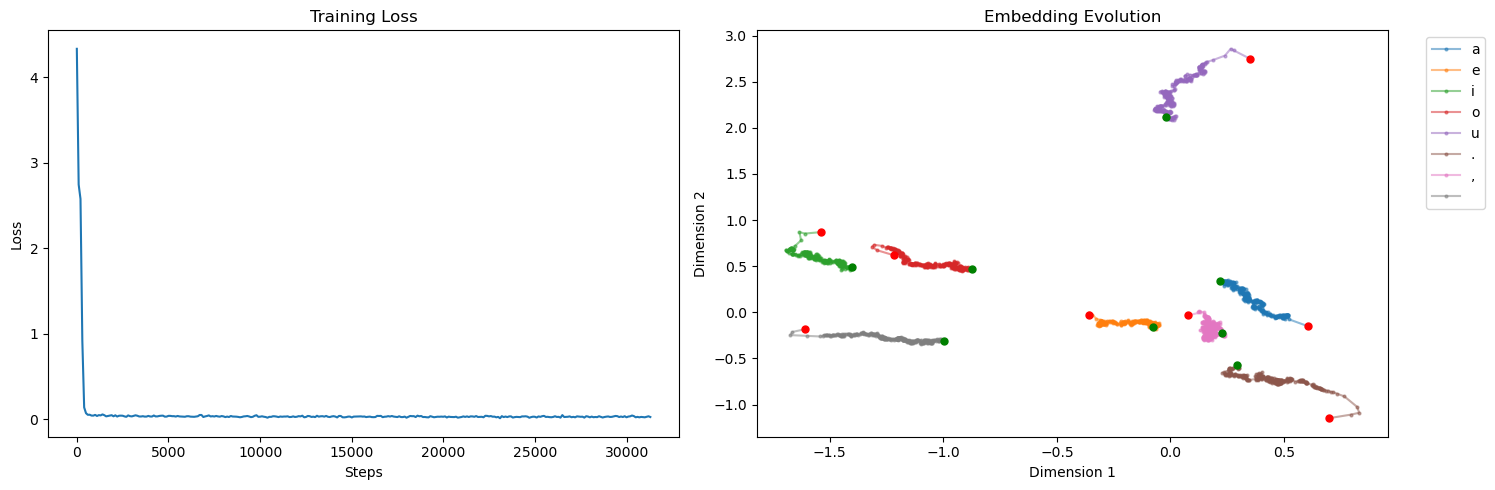

Model saved to shakespeare_model.pth


In [16]:
# Usage:
# Train the model
#model = train_model()

# Train model and track embeddings
model, embedding_history, loss_history, global_steps, chars_to_track = train_model_with_embedding_tracking()

# Save the model
save_model(model)

# Embedding Evolution Analysis

## Overall Pattern
The plot shows how different characters' embeddings evolved in 2D space during training, with each character's trajectory shown in a different color. Red dots mark starting positions and green dots mark ending positions.

## Color-Coded Characters
- Blue trajectory: 'a' - Shows movement in the lower right quadrant 
- Orange trajectory: 'e' - Positioned near the middle of the plot
- Green trajectory: 'i' - Located in the upper portion
- Red trajectory: 'o' - Shows movement in the middle region
- Purple trajectory: 'u' - Located in the uppermost portion of the plot
- Brown/Gray trajectories: '.' and ',' (punctuation) - Found in the lower portion
- Pink/Light trajectory: Space character (' ') - Distinct from both vowels and punctuation

## Character Clustering
- Vowels ('a', 'e', 'i', 'o', 'u') have formed distinct clusters in different regions
- Related vowels ended up closer to each other (e.g., 'o' and 'i' show some proximity)
- Punctuation marks (',' and '.') and space character (' ') are clearly separated from vowels, suggesting the model learned fundamental differences between character types

## Movement Patterns
- Each colored trajectory shows smooth movement from red dot (start) to green dot (end)
- Trajectories don't cross much, suggesting stable learning of relative relationships
- Characters maintain consistent distances once settled, visible in the parallel nature of some trajectories
- Space and punctuation embeddings (lighter colors) are distinctly clustered away from vowels (darker colors)

## Training Implications
- Loss plot (left) shows rapid early reduction then stabilization
- Embedding trajectories mirror this: large initial movements followed by fine-tuning
- Final positions show clear separation between character types, indicating learned linguistic distinctions

In [12]:
# Load the model
loaded_model = load_model()

# Get embeddings from loaded model
embeddings = loaded_model.token_embedding.weight.data
print("\nEmbedding shape:", embeddings.shape)

# Simple similarity analysis
def find_similar_chars(char, top_k=3):
    char_idx = stoi[char]
    char_embedding = embeddings[char_idx]
    similarities = F.cosine_similarity(char_embedding.unsqueeze(0), embeddings)
    values, indices = torch.topk(similarities, top_k)
    return [(itos[idx.item()], sim.item()) for idx, sim in zip(indices, values)]

# Print similarities for example characters
for char in ['a', 'e', 't']:
    print(f"\nSimilar characters to '{char}':")
    print(find_similar_chars(char))

# Optional: Print some basic statistics about the embeddings
print("\nEmbedding Statistics:")
print(f"Mean embedding magnitude: {torch.norm(embeddings, dim=1).mean():.3f}")
print(f"Std of embedding magnitudes: {torch.norm(embeddings, dim=1).std():.3f}")

# Compare a specific pair of characters
char1, char2 = 'a', 'e'
emb1 = embeddings[stoi[char1]]
emb2 = embeddings[stoi[char2]]
similarity = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
print(f"\nSimilarity between '{char1}' and '{char2}': {similarity.item():.3f}")


Embedding shape: torch.Size([65, 64])

Similar characters to 'a':
[('a', 0.9999999403953552), ('A', 0.4429907500743866), ('i', 0.21488821506500244)]

Similar characters to 'e':
[('e', 1.0000001192092896), ('E', 0.25732171535491943), ('$', 0.2175978720188141)]

Similar characters to 't':
[('t', 1.0000001192092896), ('T', 0.4925515651702881), ('d', 0.20808997750282288)]

Embedding Statistics:
Mean embedding magnitude: 2.662
Std of embedding magnitudes: 0.182

Similarity between 'a' and 'e': 0.151


In [13]:
# Test the generation with different prompts
test_prompts = [
    #"GREMIO: Good morrow, neighbour Baptista.",
    #"ROMEO: O, she doth teach the torches to burn bright!",
    "HAMLET: To be, or not to be,"
]

for prompt in test_prompts:
    print("\nPrompt:", prompt)
    print("-" * 50)
    
    # Encode prompt
    context = torch.tensor([encode(prompt)], dtype=torch.long)
    
    # Generate completion
    with torch.no_grad():
        generated = loaded_model.generate(context, max_new_tokens=50, temperature=0.7)[0]
        
    # Print result
    generated_text = decode(generated.tolist())
    prompt_len = len(prompt)
    print("Completion:")
    print(generated_text[prompt_len:])
    print("-" * 50)


Prompt: HAMLET: To be, or not to be,
--------------------------------------------------
Completion:

And you I have hear in might compary may a recand
--------------------------------------------------


PCA Visualization:


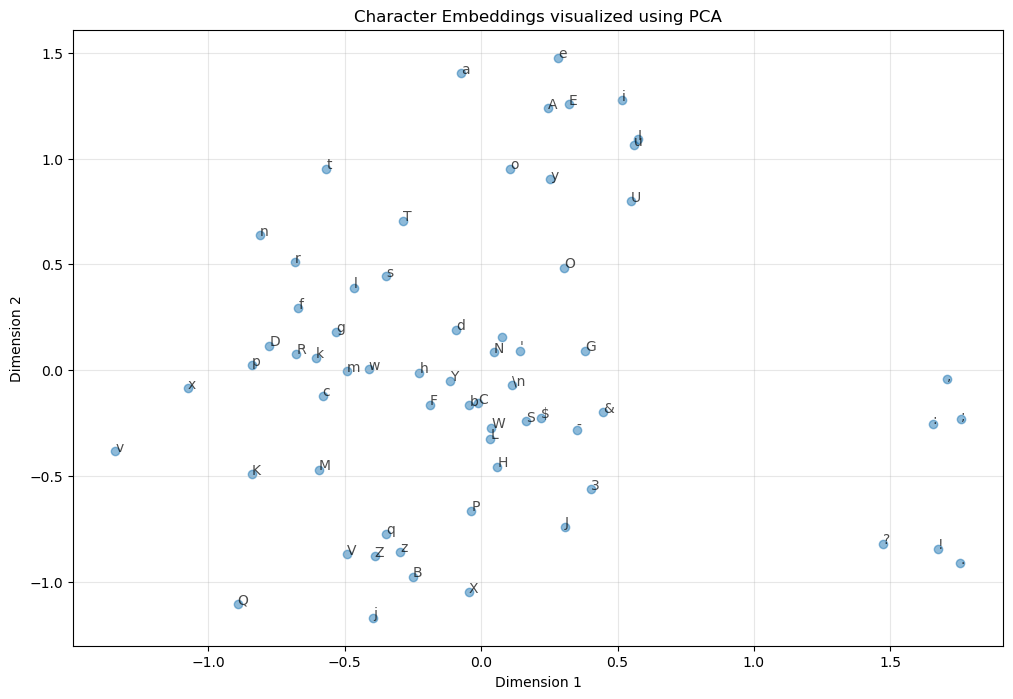


t-SNE Visualization:


/Users/pranavdhinakar/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/pranavdhinakar/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


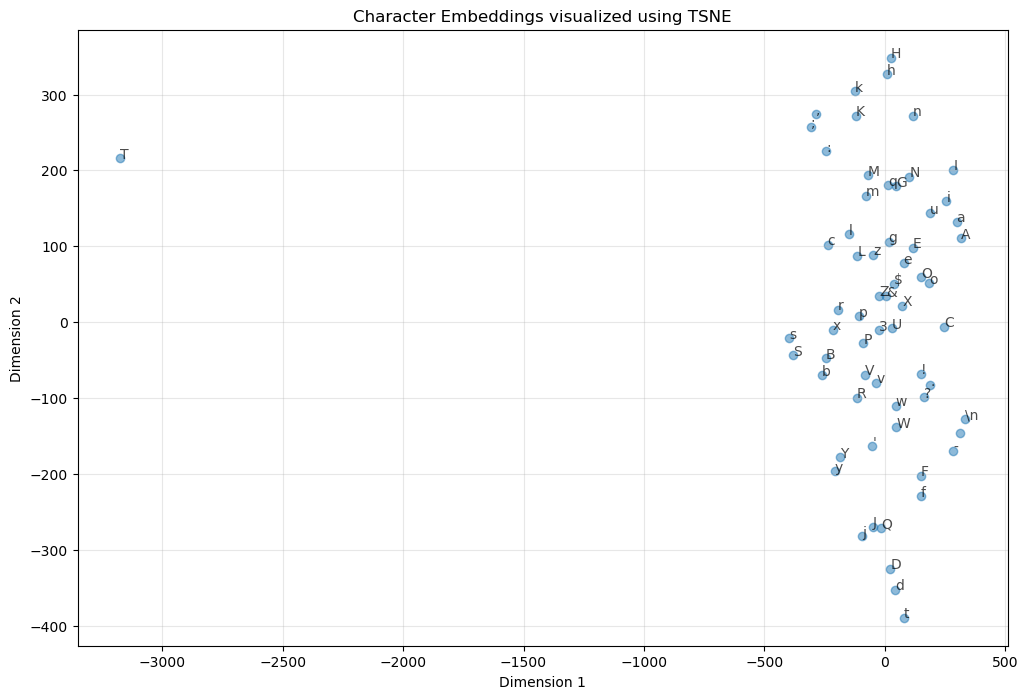

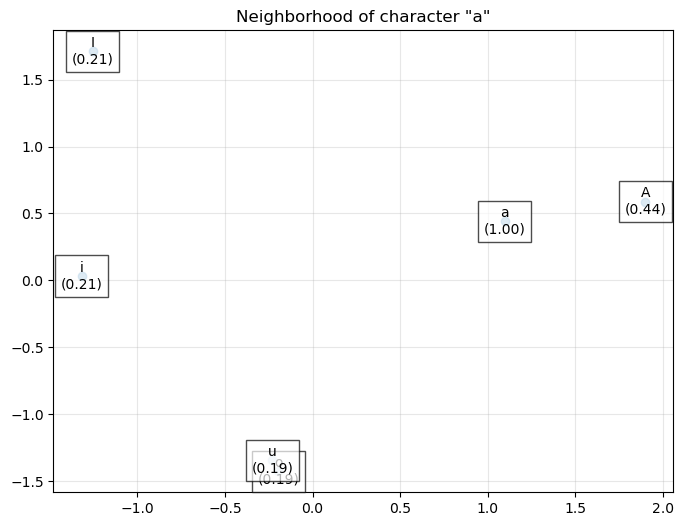

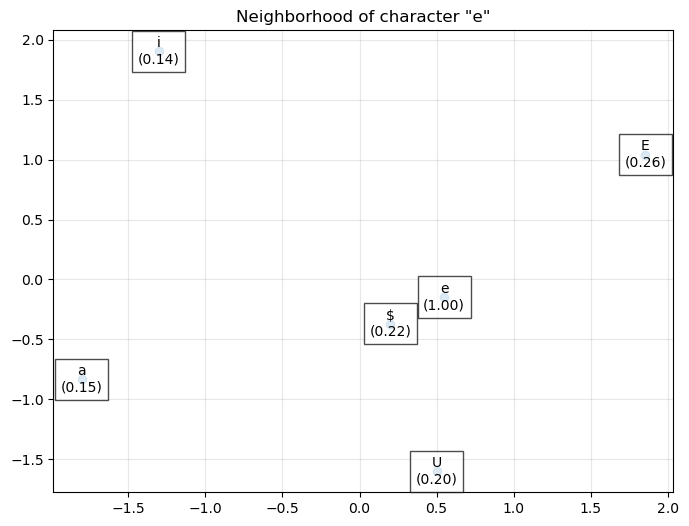

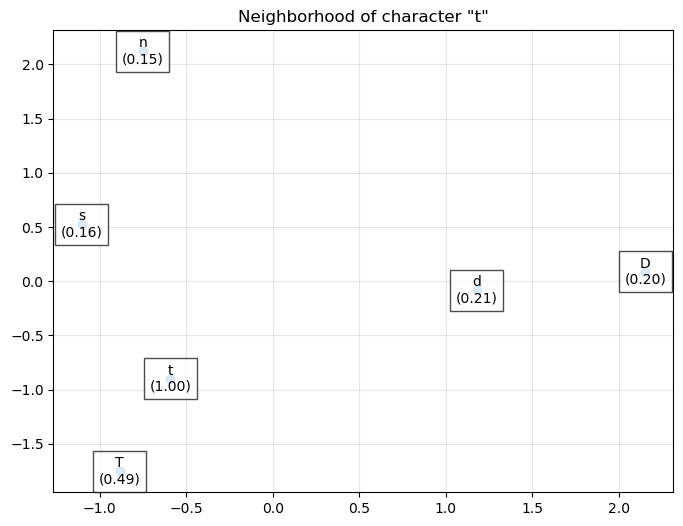

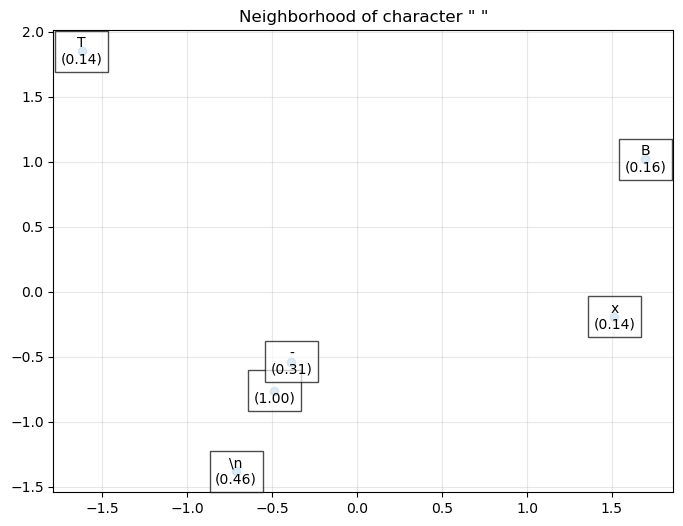

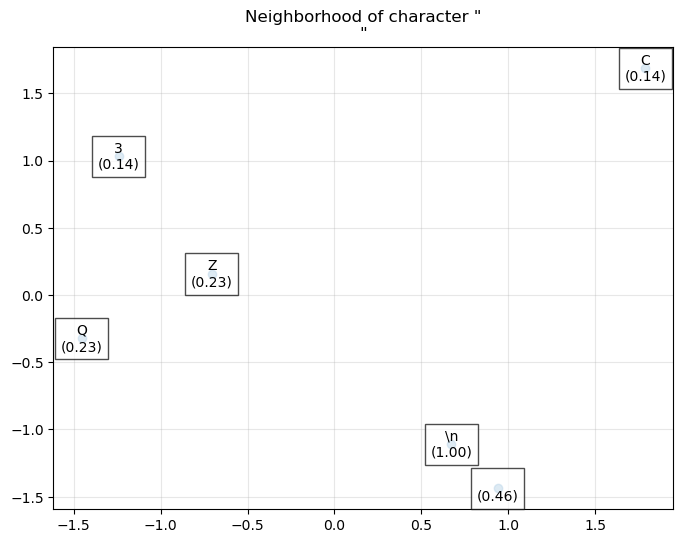

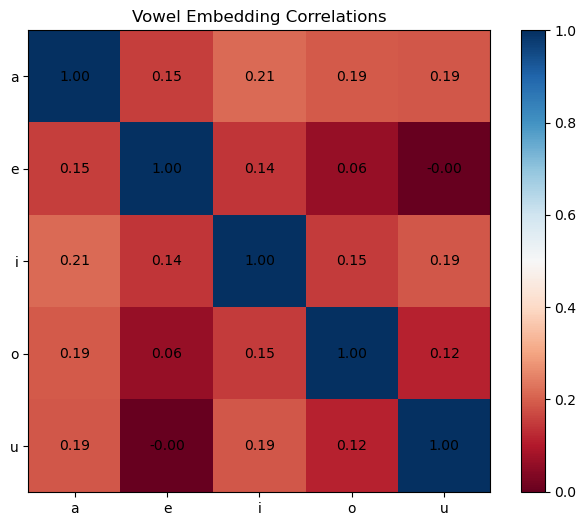

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(model, method='pca'):
    # Get embeddings
    embeddings = model.token_embedding.weight.data.numpy()
    
    # Choose dimensionality reduction method
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:  # t-SNE
        reducer = TSNE(n_components=2, perplexity=5, random_state=42)
    
    # Reduce to 2 dimensions
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    
    # Add labels for each point
    for i, (x, y) in enumerate(embeddings_2d):
        char = itos[i]
        if char == '\n': char = '\\n'  # Make newline visible
        plt.annotate(char, (x, y), alpha=0.7)
    
    plt.title(f'Character Embeddings visualized using {method.upper()}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize using both methods
print("PCA Visualization:")
visualize_embeddings(loaded_model, 'pca')

print("\nt-SNE Visualization:")
visualize_embeddings(loaded_model, 'tsne')

# You can also visualize specific character relationships
def plot_character_neighborhood(model, character, k=5):
    embeddings = model.token_embedding.weight.data
    char_idx = stoi[character]
    char_embedding = embeddings[char_idx]
    
    # Calculate similarities
    similarities = F.cosine_similarity(char_embedding.unsqueeze(0), embeddings)
    values, indices = torch.topk(similarities, k+1)  # +1 because the character itself will be included
    
    # Get the embeddings of the most similar characters
    similar_embeddings = embeddings[indices]
    
    # Reduce to 2D
    reducer = PCA(n_components=2)
    embeddings_2d = reducer.fit_transform(similar_embeddings.numpy())
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    
    # Add labels
    for i, (x, y) in enumerate(embeddings_2d):
        char = itos[indices[i].item()]
        if char == '\n': char = '\\n'
        similarity = values[i].item()
        plt.annotate(f'{char}\n({similarity:.2f})', (x, y), 
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title(f'Neighborhood of character "{character}"')
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot neighborhoods for some interesting characters
for char in ['a', 'e', 't', ' ', '\n']:
    plot_character_neighborhood(loaded_model, char)

# You can also create a correlation matrix for vowels
def plot_vowel_correlations(model):
    vowels = ['a', 'e', 'i', 'o', 'u']
    embeddings = model.token_embedding.weight.data
    
    # Get vowel embeddings
    vowel_indices = [stoi[v] for v in vowels]
    vowel_embeddings = embeddings[vowel_indices]
    
    # Calculate correlation matrix
    correlations = torch.zeros((len(vowels), len(vowels)))
    for i, emb1 in enumerate(vowel_embeddings):
        for j, emb2 in enumerate(vowel_embeddings):
            correlations[i,j] = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(correlations, cmap='RdBu')
    plt.colorbar()
    
    # Add labels
    plt.xticks(range(len(vowels)), vowels)
    plt.yticks(range(len(vowels)), vowels)
    
    # Add values in cells
    for i in range(len(vowels)):
        for j in range(len(vowels)):
            plt.text(j, i, f'{correlations[i,j]:.2f}', 
                    ha='center', va='center')
    
    plt.title('Vowel Embedding Correlations')
    plt.show()

plot_vowel_correlations(loaded_model)

In [ ]:
# Visualize the evolution of embeddings
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(121)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Steps (x100)')
plt.ylabel('Loss')

# Plot embedding changes for first two dimensions
plt.subplot(122)
embedding_history = np.array(embedding_history)
for i, char in enumerate(chars_to_track):
    # Plot trajectory of each character
    plt.plot(embedding_history[:, i, 0], embedding_history[:, i, 1], 'o-', label=char, alpha=0.5)
    # Mark start and end points
    plt.plot(embedding_history[0, i, 0], embedding_history[0, i, 1], 'o', color='red')  # start
    plt.plot(embedding_history[-1, i, 0], embedding_history[-1, i, 1], 'o', color='green')  # end

plt.title('Embedding Evolution (First 2 Dimensions)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

# You could also create an animation
from matplotlib.animation import FuncAnimation

def animate_embeddings():
    fig, ax = plt.subplots(figsize=(8, 8))
    
    def update(frame):
        ax.clear()
        # Plot each character at this frame
        for i, char in enumerate(chars_to_track):
            ax.scatter(embedding_history[frame, i, 0], 
                      embedding_history[frame, i, 1],
                      label=char)
            ax.annotate(char, (embedding_history[frame, i, 0], 
                             embedding_history[frame, i, 1]))
        
        ax.set_title(f'Frame {frame}, Loss: {loss_history[frame]:.3f}')
        ax.legend()
        ax.set_xlim([embedding_history[:,:,0].min(), embedding_history[:,:,0].max()])
        ax.set_ylim([embedding_history[:,:,1].min(), embedding_history[:,:,1].max()])
        
    anim = FuncAnimation(fig, update, frames=len(embedding_history), 
                        interval=100, repeat=False)
    plt.show()

# Create animation
animate_embeddings()